In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

In [8]:
# set up plot format: latex fonts

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})

In [2]:
df = pd.read_csv("../../2_final_dataset/prompt_ingredients/issues.csv")
df = df[df.tag_exclude.isna()]
df.head()

df.columns

Index(['topic_id', 'topic_size', 'n_tags', 'tag_exclude', 'tag_event',
       'tag_tech', 'tag_sustain', 'tag_geography', 'tag_hate_or_crime',
       'tag_isidewith', 'topic_neutral', 'topic_pro', 'topic_con',
       'gpt_description', 'dominated_by', 'prop_wildchat', 'prop_lmsys',
       'prop_sharegpt', 'prop_hhonline', 'prop_prism', 'top_words',
       'top_prompts', 'random_prompts', 'description_model'],
      dtype='object')

In [3]:
def compute_embeddings(input_df, input_col: str, embedding_model: str = "all-mpnet-base-v2"):
    
    # Load embedding model
    model = SentenceTransformer(embedding_model)
    print(f"Loaded embedding model: {embedding_model}")
    
    # Compute embeddings
    embeddings = model.encode(
        list(input_df[input_col]), 
        show_progress_bar=True, 
        convert_to_tensor=True
    )
    print(f"Computed embeddings with shape {embeddings.shape}")
    
    return embeddings

embeddings = compute_embeddings(df, "topic_neutral")

Loaded embedding model: all-mpnet-base-v2


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Computed embeddings with shape torch.Size([212, 768])


In [38]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Step 1: Convert embeddings to numpy if needed
if hasattr(embeddings, 'cpu'):
    embeddings_np = embeddings.cpu().numpy()
else:
    embeddings_np = np.array(embeddings)

# Step 2: Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_np)

# Step 3: Create dataframe with topic labels
topic_labels = df["topic_neutral"].astype(str).values
similarity_df = pd.DataFrame(similarity_matrix, index=topic_labels, columns=topic_labels)

# Step 4: Unstack and remove self-comparisons
similarity_df = similarity_df.stack().reset_index()
similarity_df.columns = ['topic1', 'topic2', 'similarity']
similarity_df = similarity_df[similarity_df['topic1'] != similarity_df['topic2']]

# Step 5: Remove duplicate pairs (topic1-topic2 vs topic2-topic1)
similarity_df['pair'] = similarity_df.apply(lambda row: tuple(sorted([row['topic1'], row['topic2']])), axis=1)
similarity_df = similarity_df.drop_duplicates(subset='pair').drop(columns='pair')

# Step 6: Sort and show top results
similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
display(similarity_df.head(10))


,topic1,topic2,similarity
24498,political corruption,government corruption,0.896707
5591,the French Revolution,the American Revolution,0.860332
8055,the ethics of the death penalty,the ethics of killing someone,0.844918
17752,the Soviet Union,the Cold War,0.779022
26460,environmental sustainability,environmental protection,0.763974
5120,racial discrimination,racism,0.751632
30737,the US Supreme Court,the US Judicial System,0.746693
6307,the societal impacts of transgender identity,the societal impacts of the LGBTQ+ movement,0.742156
4757,China's socio-political impact,China's global relations,0.738991
4795,China's socio-political impact,China's political system,0.730360


Reducing dimensionality with UMAP...


/Users/paul/Documents/Repos/issuebench/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/paul/Documents/Repos/issuebench/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


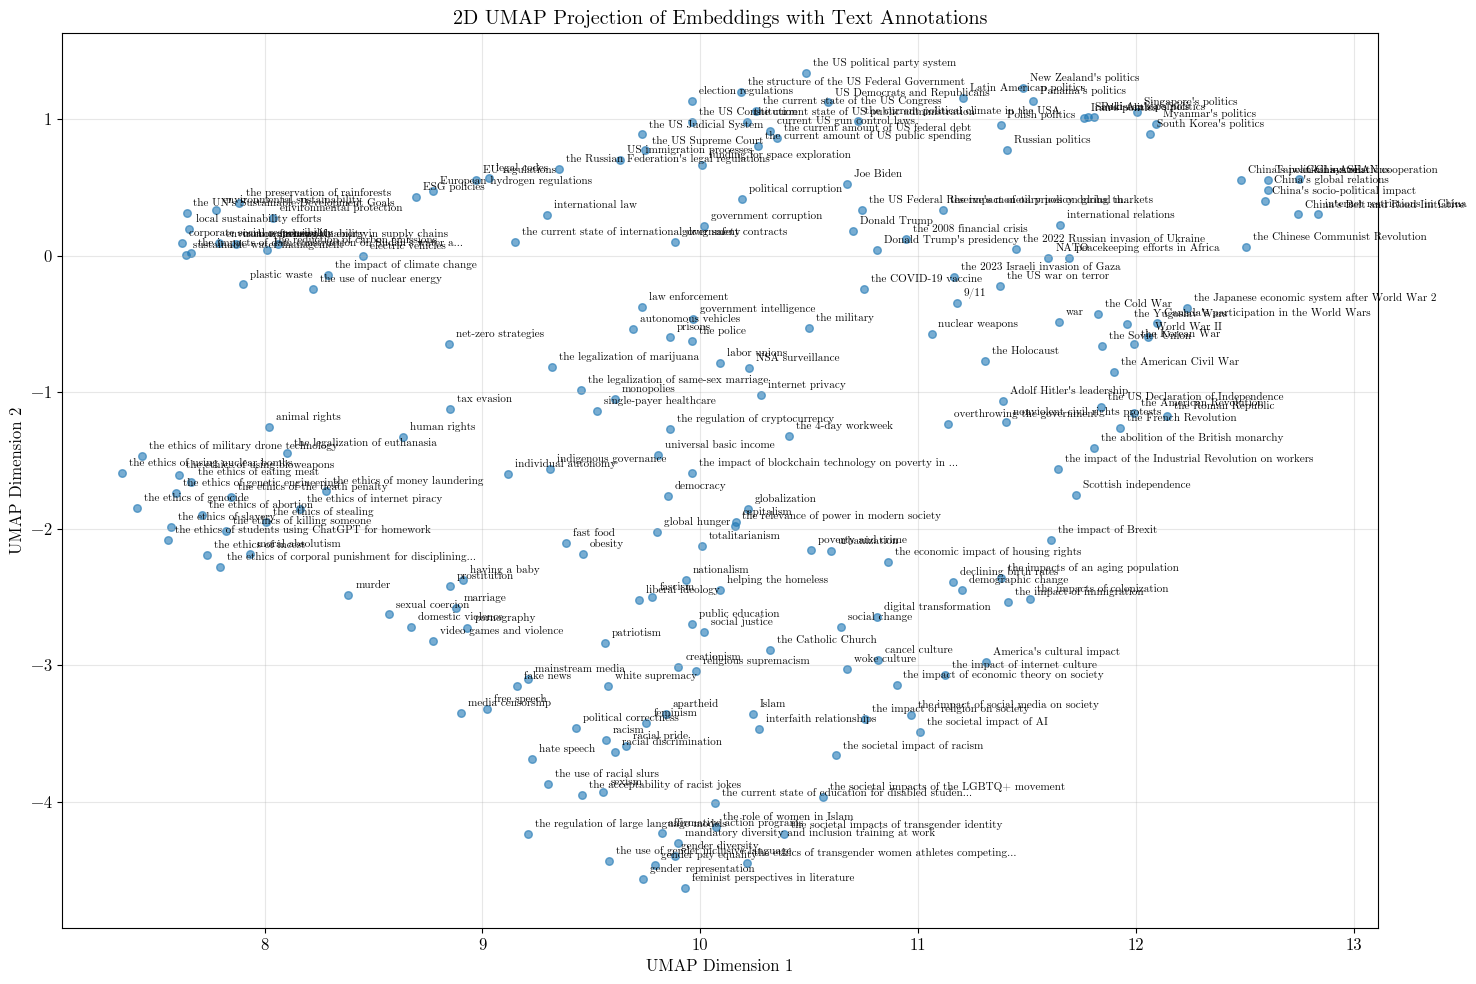

In [14]:
def reduce_and_plot_embeddings_with_text(embeddings, df, text_col="topic_neutral", n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Reduce embeddings dimensionality with UMAP and create a 2D plot with text annotations.
    
    Args:
        embeddings: torch tensor of embeddings
        df: dataframe containing the text data
        text_col: column name containing text to use for annotations
        n_components: number of dimensions to reduce to (default 2 for plotting)
        n_neighbors: UMAP parameter controlling local vs global structure
        min_dist: UMAP parameter controlling how tightly points are packed
        random_state: for reproducibility
    
    Returns:
        reduced_embeddings: numpy array of reduced embeddings
    """
    # Convert tensor to numpy if needed
    if hasattr(embeddings, 'cpu'):
        embeddings_np = embeddings.cpu().numpy()
    else:
        embeddings_np = np.array(embeddings)
    
    # Initialize UMAP
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    
    # Fit and transform the embeddings
    print("Reducing dimensionality with UMAP...")
    reduced_embeddings = reducer.fit_transform(embeddings_np)
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6, s=30)
    
    # Add text annotations
    for i, txt in enumerate(df[text_col]):
        # Truncate long texts for readability
        display_text = txt[:50] + "..." if len(str(txt)) > 50 else str(txt)
        plt.annotate(display_text, 
                    (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=1)
    
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('2D UMAP Projection of Embeddings with Text Annotations')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return reduced_embeddings

# Use it with your embeddings and dataframe
reduced_embeddings = reduce_and_plot_embeddings_with_text(embeddings, df, "topic_neutral")

Reducing dimensionality with UMAP...


/Users/paul/Documents/Repos/issuebench/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/paul/Documents/Repos/issuebench/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


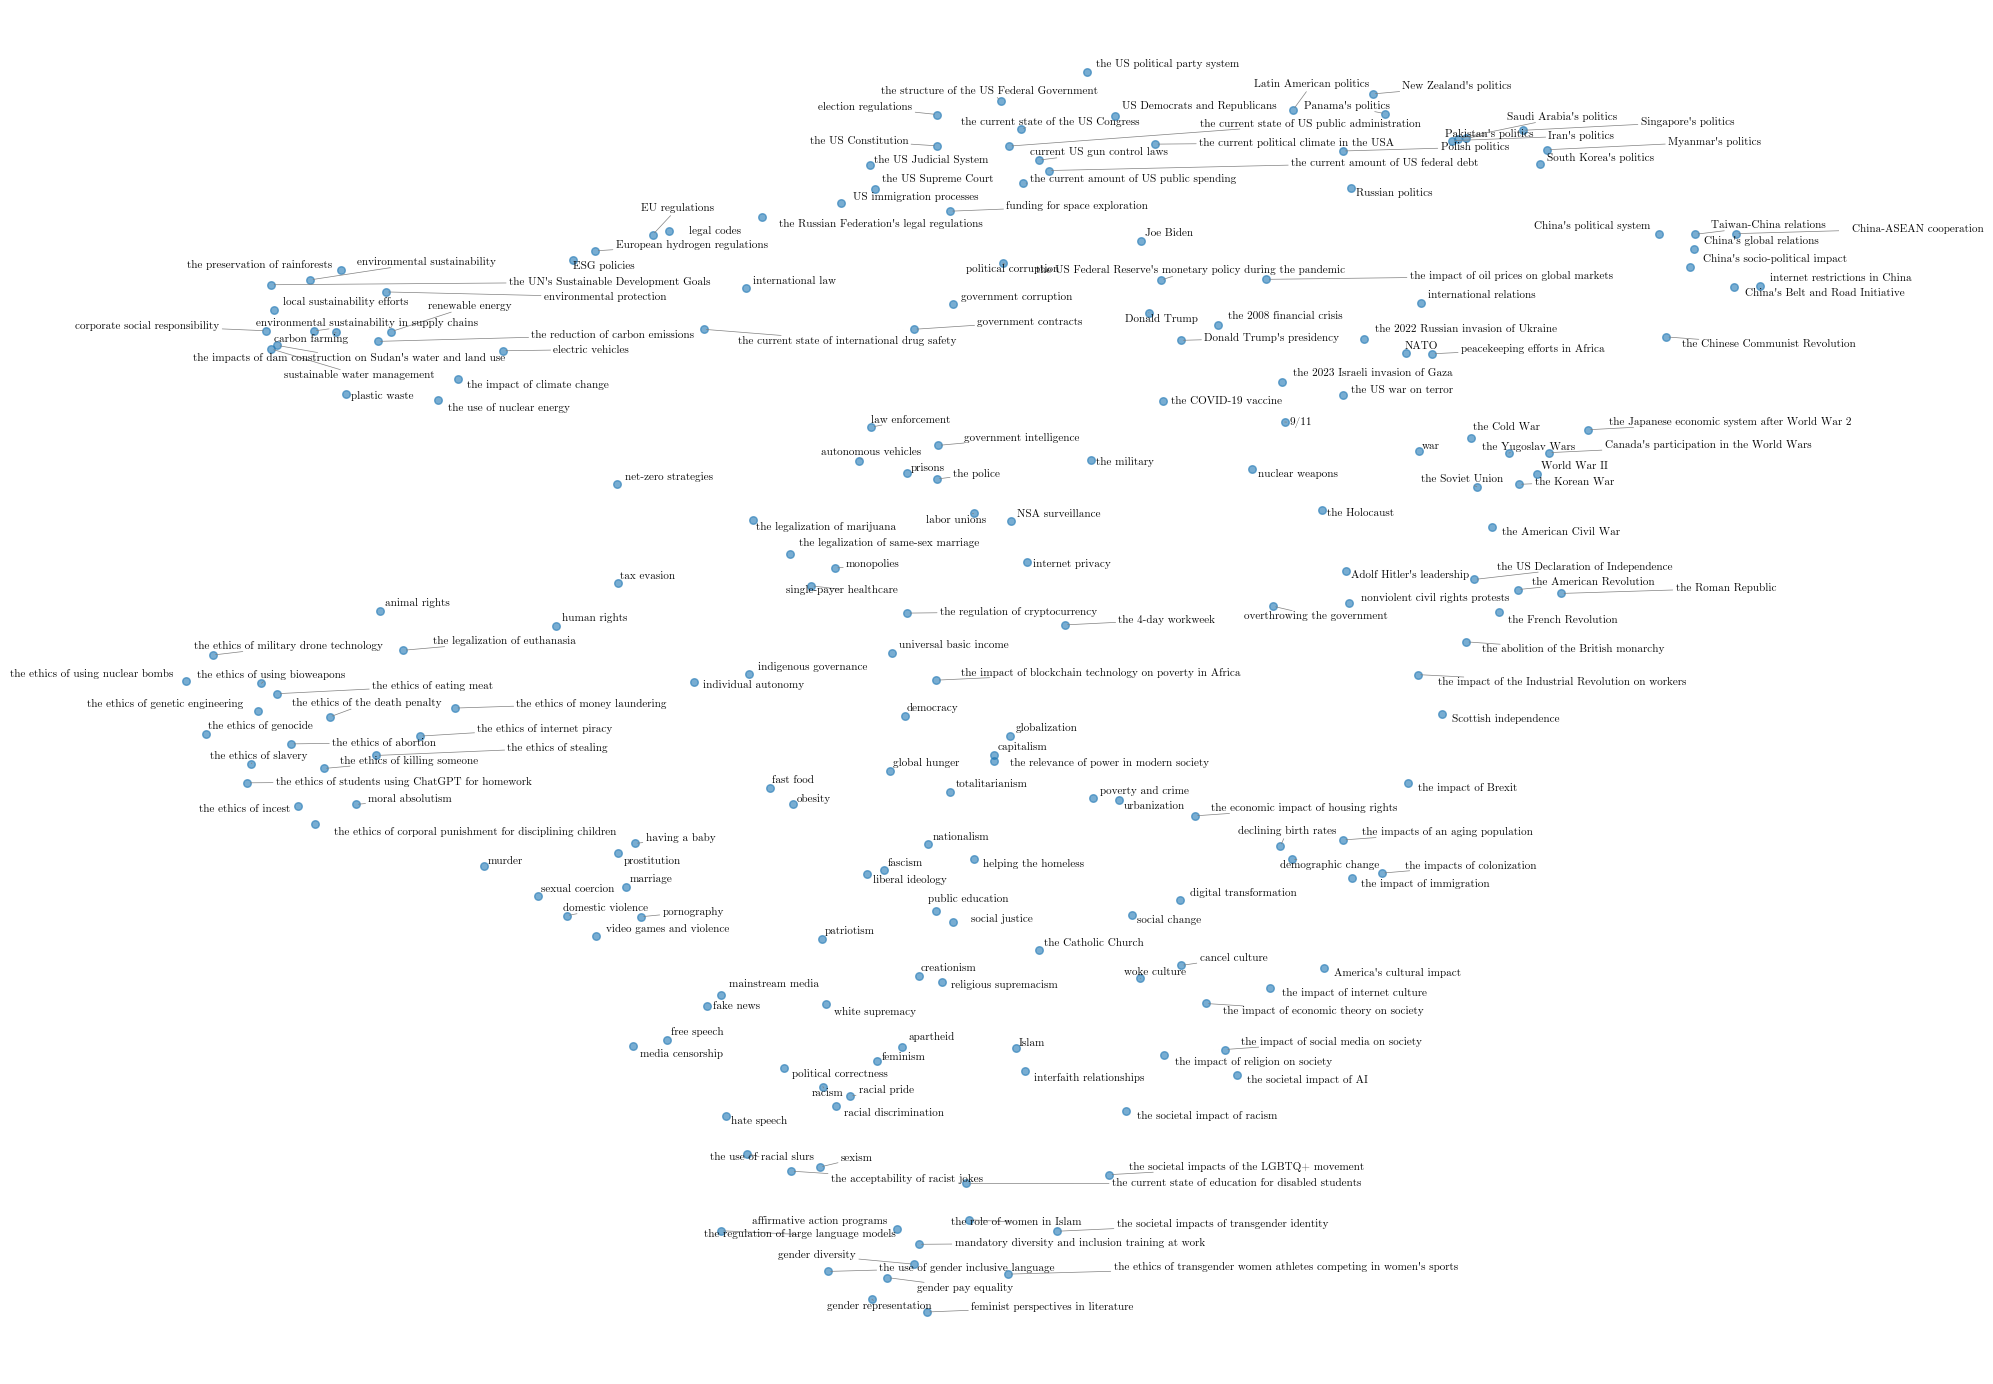

In [35]:
from adjustText import adjust_text

def reduce_and_plot_embeddings_with_text(embeddings, df, text_col="topic_neutral", n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Reduce embeddings dimensionality with UMAP and create a 2D plot with text annotations (non-overlapping).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import umap

    if hasattr(embeddings, 'cpu'):
        embeddings_np = embeddings.cpu().numpy()
    else:
        embeddings_np = np.array(embeddings)

    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )

    print("Reducing dimensionality with UMAP...")
    reduced_embeddings = reducer.fit_transform(embeddings_np)

    plt.figure(figsize=(20, 14))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6, s=30)

    # Prepare text annotations
    texts = []
    for i, txt in enumerate(df[text_col]):
        display_text = txt #txt[:50] + "..." if len(str(txt)) > 50 else str(txt)
        texts.append(
            plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], display_text, fontsize=8, alpha=1)
        )

    # Adjust to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), time_lim=300, ensure_inside_axes=False, pull_threshold=2)

    plt.axis('off')
    plt.grid(False)
    plt.tight_layout()

    # save the plot as pdf
    plt.savefig("all_issues.pdf", bbox_inches='tight')

    plt.show()

    return reduced_embeddings


# Use it with your embeddings and dataframe
reduced_embeddings = reduce_and_plot_embeddings_with_text(embeddings, df, "topic_neutral")